In [1]:
import os
import librosa
import numpy as np
import pandas as pd
import warnings
import zipfile
import requests
import math
from tqdm.auto import tqdm
from google.colab import files
from concurrent.futures import ProcessPoolExecutor, as_completed
from dataclasses import dataclass
from typing import Optional, List, Tuple, Any
import gc

# CONFIGURATION
@dataclass
class AudioConfig:
    sample_rate: int = 22050
    n_chroma: int = 24          # 24 bins for quarter tones
    n_mfcc: int = 20            # Standard for voice/timbre
    n_contrast_bands: int = 7   # Spectral contrast
    min_audio_duration: float = 2.0  # Increased min duration to avoid tiny chunks
    max_audio_duration: float = 30.0 # This is now the CHUNK size
    trim_top_db: int = 20
    cqt_bins_per_octave: int = 24
    cqt_n_octaves: int = 7
    hop_length: int = 1024
    n_fft: int = 2048
    min_valid_length: float = 0.5

@dataclass
class ProcessingConfig:
    max_workers: int = 2 # Set to 2 for Colab stability

AUDIO_CONFIG = AudioConfig()
PROCESSING_CONFIG = ProcessingConfig()
warnings.filterwarnings('ignore')

# 1. DATASET HELPER (DOWNLOADER)
def download_and_extract_figshare(target_dir="dataset_root"):
    """Downloads the specific Maqam478 dataset from Figshare."""
    url = "https://figshare.com/ndownloader/files/26372272"
    zip_path = "maqam_dataset.zip"

    if not os.path.exists(target_dir):
        os.makedirs(target_dir)

    print(f"Downloading dataset from Figshare (File ID: 26372272)...")
    try:
        response = requests.get(url, stream=True)
        total_size = int(response.headers.get('content-length', 0))
        block_size = 1024

        with open(zip_path, 'wb') as file, tqdm(
            desc="Downloading",
            total=total_size,
            unit='iB',
            unit_scale=True,
            unit_divisor=1024,
        ) as bar:
            for data in response.iter_content(block_size):
                size = file.write(data)
                bar.update(size)

        print("Extracting dataset...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(target_dir)

        os.remove(zip_path)
        print("✓ Download and extraction complete.")
        return target_dir

    except Exception as e:
        print(f"Error downloading dataset: {e}")
        return None

# 2. DATASET PARSER
class DatasetParser:
    def __init__(self, root_path: str):
        self.root_path = root_path

    def find_dataset_root(self) -> str:
        if not os.path.exists(self.root_path):
            raise FileNotFoundError(f"Path '{self.root_path}' not found.")

        candidate_folders = ['Bayati', 'Rast', 'Sikah', 'Ajam', 'Nahawand', 'Saba', 'Hijaz', 'Kurd']

        print("Searching recursively for class folders...")
        for root, dirs, files in os.walk(self.root_path):
            matches = [d for d in dirs if d in candidate_folders]
            if len(matches) >= 3:
                return root

        for root, dirs, files in os.walk(self.root_path):
            if any(f.lower().endswith(('.wav', '.mp3')) for f in files):
                return os.path.dirname(root)

        return self.root_path

    def collect_audio_files(self, dataset_root: str) -> List[Tuple[str, str, str]]:
        file_tasks = []
        valid_extensions = ('.wav', '.mp3', '.flac', '.ogg', '.m4a')

        try:
            items = [d for d in os.listdir(dataset_root) if os.path.isdir(os.path.join(dataset_root, d))]
        except:
            return []

        print(f"Scanning classes: {items}")
        for label in items:
            label_dir = os.path.join(dataset_root, label)
            for f in os.listdir(label_dir):
                if f.lower().endswith(valid_extensions):
                    file_path = os.path.join(label_dir, f)
                    unique_id = f"{label}/{f}"
                    file_tasks.append((file_path, label, unique_id))
        return file_tasks

# 3. FEATURE EXTRACTOR
class FeatureExtractor:
    def __init__(self, config: AudioConfig):
        self.config = config

    def extract_features(self, y: np.ndarray, sr: int) -> Optional[List[float]]:
        try:
            features = []
            # Safety check for tiny chunks
            if len(y) < sr * self.config.min_valid_length: return None

            CQT = np.abs(librosa.cqt(
                y=y, sr=sr, hop_length=self.config.hop_length,
                bins_per_octave=self.config.cqt_bins_per_octave,
                n_bins=self.config.n_chroma * self.config.cqt_n_octaves
            ))
            S = np.abs(librosa.stft(y, n_fft=self.config.n_fft, hop_length=self.config.hop_length))

            features.extend(self._extract_pitch(CQT))
            features.extend(self._extract_timbre(S, sr))
            features.extend(self._extract_spectral(S, sr))
            features.extend(self._extract_signal(y, S))
            return features
        except:
            return None

    def _extract_pitch(self, CQT: np.ndarray) -> List[float]:
        chroma = librosa.feature.chroma_cqt(C=CQT, bins_per_octave=self.config.n_chroma, n_chroma=self.config.n_chroma)
        features = np.empty(self.config.n_chroma * 2, dtype=np.float32)
        features[0::2] = np.mean(chroma, axis=1)
        features[1::2] = np.var(chroma, axis=1)
        return features.tolist()

    def _extract_timbre(self, S: np.ndarray, sr: int) -> List[float]:
        mfcc = librosa.feature.mfcc(S=librosa.power_to_db(S), sr=sr, n_mfcc=self.config.n_mfcc, hop_length=self.config.hop_length)
        features = np.empty(self.config.n_mfcc * 2, dtype=np.float32)
        features[0::2] = np.mean(mfcc, axis=1)
        features[1::2] = np.var(mfcc, axis=1)
        return features.tolist()

    def _extract_spectral(self, S: np.ndarray, sr: int) -> List[float]:
        features = []
        centroid = librosa.feature.spectral_centroid(S=S, sr=sr, hop_length=self.config.hop_length)
        features.extend([float(np.mean(centroid)), float(np.var(centroid))])
        contrast = librosa.feature.spectral_contrast(S=S, sr=sr, hop_length=self.config.hop_length, n_bands=self.config.n_contrast_bands - 1)
        means, vars = np.mean(contrast, axis=1), np.var(contrast, axis=1)
        for i in range(self.config.n_contrast_bands):
            if i < len(means): features.extend([float(means[i]), float(vars[i])])
            else: features.extend([0.0, 0.0])
        return features

    def _extract_signal(self, y: np.ndarray, S: np.ndarray) -> List[float]:
        zcr = librosa.feature.zero_crossing_rate(y, hop_length=self.config.hop_length)
        rms = librosa.feature.rms(S=S, hop_length=self.config.hop_length)
        return [float(np.mean(zcr)), float(np.var(zcr)), float(np.mean(rms)), float(np.var(rms))]

def get_headers(config: AudioConfig) -> List[str]:
    cols = []
    for i in range(config.n_chroma): cols.extend([f'chroma_mean_{i}', f'chroma_var_{i}'])
    for i in range(config.n_mfcc): cols.extend([f'mfcc_mean_{i}', f'mfcc_var_{i}'])
    cols.extend(['centroid_mean', 'centroid_var'])
    for i in range(config.n_contrast_bands): cols.extend([f'contrast_mean_{i}', f'contrast_var_{i}'])
    cols.extend(['zcr_mean', 'zcr_var', 'rms_mean', 'rms_var', 'label'])
    return cols

# 4. PROCESSOR (UPDATED FOR SEGMENTATION)
class AudioProcessor:
    def __init__(self, audio_config):
        self.audio_config = audio_config
        self.extractor = FeatureExtractor(audio_config)

    def process_single_file(self, file_info):
        file_path, label, unique_filename = file_info
        batch_features = [] # Will store multiple rows if file > 30s

        try:
            # 1. LOAD FULL FILE (No Duration Limit Here)
            y, sr = librosa.load(file_path, sr=self.audio_config.sample_rate)

            # 2. TRIM SILENCE
            y, _ = librosa.effects.trim(y, top_db=self.audio_config.trim_top_db)

            # 3. SEGMENTATION LOOP
            # Calculate how many samples in 30 seconds
            samples_per_chunk = int(self.audio_config.max_audio_duration * sr)
            total_samples = len(y)

            # If shorter than chunk size, just process the whole thing (e.g. 20s file)
            if total_samples <= samples_per_chunk:
                features = self.extractor.extract_features(y, sr)
                if features:
                    batch_features.append(features + [label])

            # If longer, slice it up (e.g. 70s file -> 30s, 30s, 10s)
            else:
                num_chunks = math.ceil(total_samples / samples_per_chunk)

                for i in range(num_chunks):
                    start = i * samples_per_chunk
                    end = start + samples_per_chunk

                    # Get the chunk
                    y_chunk = y[start:end]

                    # Only process if this specific chunk meets min duration
                    if len(y_chunk) >= (self.audio_config.min_audio_duration * sr):
                        features = self.extractor.extract_features(y_chunk, sr)
                        if features:
                            batch_features.append(features + [label])

            return batch_features if len(batch_features) > 0 else None

        except Exception as e:
            # print(f"Error processing {file_path}: {e}") # Optional debugging
            return None

# 5. MAIN PIPELINE
def run_pipeline(dataset_path: str, output_csv: str = "maqam_features_segmented.csv"):
    print(f"MAQAM PIPELINE STARTED at: {dataset_path}")
    print(f"Mode: Segmentation (Max Chunk: {AUDIO_CONFIG.max_audio_duration}s)")

    # 1. Setup CSV
    cols = get_headers(AUDIO_CONFIG)
    pd.DataFrame(columns=cols).to_csv(output_csv, index=False)

    # 2. Collect Files
    parser = DatasetParser(dataset_path)
    real_root = parser.find_dataset_root()

    tasks = parser.collect_audio_files(real_root)

    if len(tasks) == 0:
        print("CRITICAL ERROR: NO AUDIO FILES FOUND.")
        return

    print(f"✓ Found {len(tasks)} raw audio files.")

    # 3. Process - STREAMING MODE
    processor = AudioProcessor(AUDIO_CONFIG)
    total_segments = 0
    buffer = []

    print("\nStarting Segmented Extraction...")

    with ProcessPoolExecutor(max_workers=PROCESSING_CONFIG.max_workers) as executor:
        future_to_file = {executor.submit(processor.process_single_file, t): t for t in tasks}

        with tqdm(total=len(tasks), unit="files") as pbar:
            for future in as_completed(future_to_file):
                try:
                    result_batch = future.result() # This is now a LIST of rows

                    if result_batch:
                        # Extend buffer with ALL segments found in this file
                        buffer.extend(result_batch)

                        # Write buffer to disk periodically
                        if len(buffer) >= 20:
                            pd.DataFrame(buffer, columns=cols).to_csv(output_csv, mode='a', header=False, index=False)
                            total_segments += len(buffer)
                            buffer = []

                except Exception as e:
                    pass
                pbar.update(1)

    # Write remaining buffer
    if buffer:
        pd.DataFrame(buffer, columns=cols).to_csv(output_csv, mode='a', header=False, index=False)
        total_segments += len(buffer)

    print(f"\nPipeline Finished. Extracted {total_segments} segments from {len(tasks)} files.")

    try:
        df_final = pd.read_csv(output_csv)
        print(f"✓ Final CSV has {len(df_final)} rows.")
        files.download(output_csv)
    except:
        print("Could not automatically download. Check the file browser on the left.")

if __name__ == "__main__":
    gc.collect()
    dataset_path = download_and_extract_figshare()
    if dataset_path:
        run_pipeline(dataset_path)

Downloading:   0%|          | 0.00/3.34G [00:00<?, ?iB/s]

Extracting dataset...
✓ Download and extraction complete.
MAQAM PIPELINE STARTED at: dataset_root
Mode: Segmentation (Max Chunk: 30.0s)
Searching recursively for class folders...
Scanning classes: ['Nahawand', 'Bayat', 'Kurd', 'Seka', 'Ajam', 'Hijaz', 'Rast', 'Saba']
✓ Found 478 raw audio files.

Starting Segmented Extraction...


  0%|          | 0/478 [00:00<?, ?files/s]


Pipeline Finished. Extracted 924 segments from 478 files.
✓ Final CSV has 924 rows.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [11]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
import warnings
import traceback
from typing import Tuple, List, Optional
from dataclasses import dataclass

warnings.filterwarnings('ignore')

# CONFIGURATION
@dataclass
class Config:
    """Centralized configuration for the EDA pipeline."""
    # File paths
    input_csv: str = "maqam_features_segmented.csv"
    output_csv: str = "maqam_features_processed.csv"
    figure_dir: str = 'paper_figures'

    # Analysis parameters
    seed: int = 42
    train_ratio: float = 0.8
    tsne_perplexity: int = 30
    tsne_n_iter: int = 1000
    feature_prefixes: Tuple[str, ...] = ('mfcc_mean', 'chroma_mean', 'contrast_mean')
    columns_to_exclude: Tuple[str, ...] = ('label', 'filename', 'Unnamed: 0')

    # Visualization settings
    style: str = "whitegrid"
    context: str = "paper"
    font_scale: float = 1.2
    figure_dpi: int = 150
    grid_alpha: float = 0.3

    def __post_init__(self):
        os.makedirs(self.figure_dir, exist_ok=True)
        self._setup_visualization()

    def _setup_visualization(self):
        sns.set_theme(style=self.style, context=self.context, font_scale=self.font_scale)
        plt.rcParams.update({
            'figure.dpi': self.figure_dpi,
            'savefig.bbox': 'tight',
            'axes.grid': True,
            'grid.alpha': self.grid_alpha
        })
        np.random.seed(self.seed)

CFG = Config()

# 1. DATA PROCESSING
def load_and_clean_data(file_path: str) -> pd.DataFrame:
    """Loads data and performs basic cleaning."""
    print(f"{'='*70}\nPhase 1: Data Loading\n{'='*70}")

    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File not found: {file_path}. Please run feature extraction first.")

    df = pd.read_csv(file_path)

    # Drop duplicates
    initial_len = len(df)
    df = df.drop_duplicates()
    if len(df) < initial_len:
        print(f"Removed {initial_len - len(df)} duplicate rows.")

    # Drop NaNs
    df = df.dropna()

    print(f"✓ Dataset loaded: {len(df)} samples across {df['label'].nunique()} Maqam classes.")
    return df

def split_data_stratified(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Performs a standard stratified split to maintain class balance.
    """
    print(f"\n{'='*70}\nPhase 2: Stratified Data Splitting\n{'='*70}")

    # Stratify by 'label'
    train_df, test_df = train_test_split(
        df,
        test_size=(1 - CFG.train_ratio),
        stratify=df['label'],
        random_state=CFG.seed
    )

    print(f"Training set: {len(train_df)} samples")
    print(f"Test set:     {len(test_df)} samples")

    # verify
    print("\nClass distribution (Top 5):")
    print(train_df['label'].value_counts(normalize=True).head().to_string())

    return train_df, test_df

def get_feature_columns(df: pd.DataFrame) -> List[str]:
    """Extract numeric feature columns excluding metadata."""
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    return [col for col in numeric_cols if col not in CFG.columns_to_exclude]

# 2. VISUALIZATION
class EDAPlotter:
    @staticmethod
    def plot_class_balance(train_df: pd.DataFrame, test_df: pd.DataFrame):
        print("Generating Figure 1: Class Balance...")
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))

        # Training
        train_counts = train_df['label'].value_counts()
        sns.barplot(x=train_counts.index, y=train_counts.values, ax=axes[0], palette='viridis')
        axes[0].set_title(f"Training Distribution (N={len(train_df)})", fontweight='bold')
        axes[0].tick_params(axis='x', rotation=45)

        # Test
        test_counts = test_df['label'].value_counts()
        sns.barplot(x=test_counts.index, y=test_counts.values, ax=axes[1], palette='magma')
        axes[1].set_title(f"Test Distribution (N={len(test_df)})", fontweight='bold')
        axes[1].tick_params(axis='x', rotation=45)

        plt.tight_layout()
        plt.savefig(f'{CFG.figure_dir}/Fig1_Class_Distribution.png', dpi=CFG.figure_dpi)
        plt.close()

    @staticmethod
    def plot_melodic_fingerprint(train_df: pd.DataFrame):
        print("Generating Figure 2: Melodic Fingerprint (Chroma)...")
        chroma_cols = [c for c in train_df.columns if 'chroma_mean' in c]
        if not chroma_cols: return

        # Sort columns to ensure 0-11 or 0-23 order
        chroma_cols.sort(key=lambda x: int(x.split('_')[-1]))

        maqam_profiles = train_df[chroma_cols + ['label']].groupby('label').mean()

        plt.figure(figsize=(14, 6))
        sns.heatmap(maqam_profiles, cmap='magma', linewidths=0.5)
        plt.title("Mean Chroma Profile (Quarter-Tone Bins)", fontweight='bold')
        plt.xlabel("Chroma Bin Index")
        plt.ylabel("Maqam")
        plt.tight_layout()
        plt.savefig(f'{CFG.figure_dir}/Fig2_Melodic_Fingerprint.png', dpi=CFG.figure_dpi)
        plt.close()

    @staticmethod
    def plot_tsne_manifold(train_df: pd.DataFrame):
        print("Generating Figure 3: t-SNE Manifold...")
        feature_cols = get_feature_columns(train_df)
        if len(feature_cols) < 2: return

        if len(train_df) > 5000:
            plot_df = train_df.sample(5000, random_state=CFG.seed)
        else:
            plot_df = train_df.copy()

        X = plot_df[feature_cols].fillna(0)
        X_scaled = StandardScaler().fit_transform(X)

        tsne = TSNE(n_components=2, random_state=CFG.seed,
                    perplexity=CFG.tsne_perplexity, n_iter=CFG.tsne_n_iter, n_jobs=-1)

        X_embedded = tsne.fit_transform(X_scaled)

        tsne_df = pd.DataFrame(X_embedded, columns=['Dim1', 'Dim2'])
        tsne_df['Maqam'] = plot_df['label'].values

        plt.figure(figsize=(10, 8))
        sns.scatterplot(data=tsne_df, x='Dim1', y='Dim2', hue='Maqam', palette='bright', alpha=0.7, s=40)
        plt.title("t-SNE Projection of Acoustic Features", fontweight='bold')
        plt.tight_layout()
        plt.savefig(f'{CFG.figure_dir}/Fig3_tSNE_Manifold.png', dpi=CFG.figure_dpi)
        plt.close()

    @staticmethod
    def plot_correlation_matrix(train_df: pd.DataFrame):
        print("Generating Figure 4: Feature Correlations (Square)...")

        subset_cols = []
        # Take first 3 of each type
        for prefix in ['mfcc_mean', 'chroma_mean', 'contrast_mean']:
            cols = [c for c in train_df.columns if prefix in c]
            subset_cols.extend(cols[:3])

        # Add physics-based features
        spec_features = ['zcr_mean', 'rms_mean']
        subset_cols.extend([c for c in spec_features if c in train_df.columns])

        if len(subset_cols) < 2: return

        corr = train_df[subset_cols].corr()
        # mask = np.triu(np.ones_like(corr, dtype=bool)) # REMOVED MASK

        plt.figure(figsize=(12, 10))

        sns.heatmap(
            corr,
            # mask=mask, # REMOVED MASK ARGUMENT
            cmap='coolwarm',
            center=0,
            annot=True,
            fmt=".2f",
            square=True,
            cbar_kws={"shrink": 0.8},
            annot_kws={"size": 10}
        )

        plt.title("Feature Correlation Matrix (Subset)", fontweight='bold', pad=20)
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)

        plt.tight_layout()
        plt.savefig(f'{CFG.figure_dir}/Fig4_Correlation_Matrix.png', dpi=CFG.figure_dpi, bbox_inches='tight')
        plt.close()

# 3. PIPELINE RUNNER
def run_eda_pipeline():
    try:
        print("=" * 70)
        print("MAQAM EDA PIPELINE (Standard Stratified)")
        print("=" * 70)

        # 1. Load
        df = load_and_clean_data(CFG.input_csv)

        # 2. Split
        train_df, test_df = split_data_stratified(df)

        # 3. Save Processed
        train_df.to_csv("train_split.csv", index=False)
        test_df.to_csv("test_split.csv", index=False)
        print("✓ Saved train_split.csv and test_split.csv")

        # 4. Plot
        print(f"\n{'='*70}\nPhase 3: Generating Visuals\n{'='*70}")
        plotter = EDAPlotter()
        plotter.plot_class_balance(train_df, test_df)
        plotter.plot_melodic_fingerprint(train_df)
        plotter.plot_tsne_manifold(train_df)
        plotter.plot_correlation_matrix(train_df)

        print(f"\nPipeline Finished. Figures saved in '{CFG.figure_dir}/'")

    except Exception as e:
        print(f"\nERROR: {e}")
        traceback.print_exc()

if __name__ == "__main__":
    run_eda_pipeline()

MAQAM EDA PIPELINE (Standard Stratified)
Phase 1: Data Loading
✓ Dataset loaded: 924 samples across 8 Maqam classes.

Phase 2: Stratified Data Splitting
Training set: 739 samples
Test set:     185 samples

Class distribution (Top 5):
label
Hijaz       0.147497
Rast        0.144790
Saba        0.123139
Nahawand    0.121786
Bayat       0.121786
✓ Saved train_split.csv and test_split.csv

Phase 3: Generating Visuals
Generating Figure 1: Class Balance...
Generating Figure 2: Melodic Fingerprint (Chroma)...
Generating Figure 3: t-SNE Manifold...
Generating Figure 4: Feature Correlations (Square)...

Pipeline Finished. Figures saved in 'paper_figures/'


Loading data...
Training models...
  Optimizing Logistic Regression...
  Optimizing KNN...
  Optimizing Random Forest...
  Optimizing SVM...

Results:
                  Model  Accuracy  Precision    Recall  F1 Score
0  Logistic Regression  0.875676   0.874585  0.875676  0.874503
1                  KNN  0.908108   0.916826  0.908108  0.909230
2        Random Forest  0.908108   0.909155  0.908108  0.908098
3                  SVM  0.967568   0.968116  0.967568  0.967624

Generating Figures...


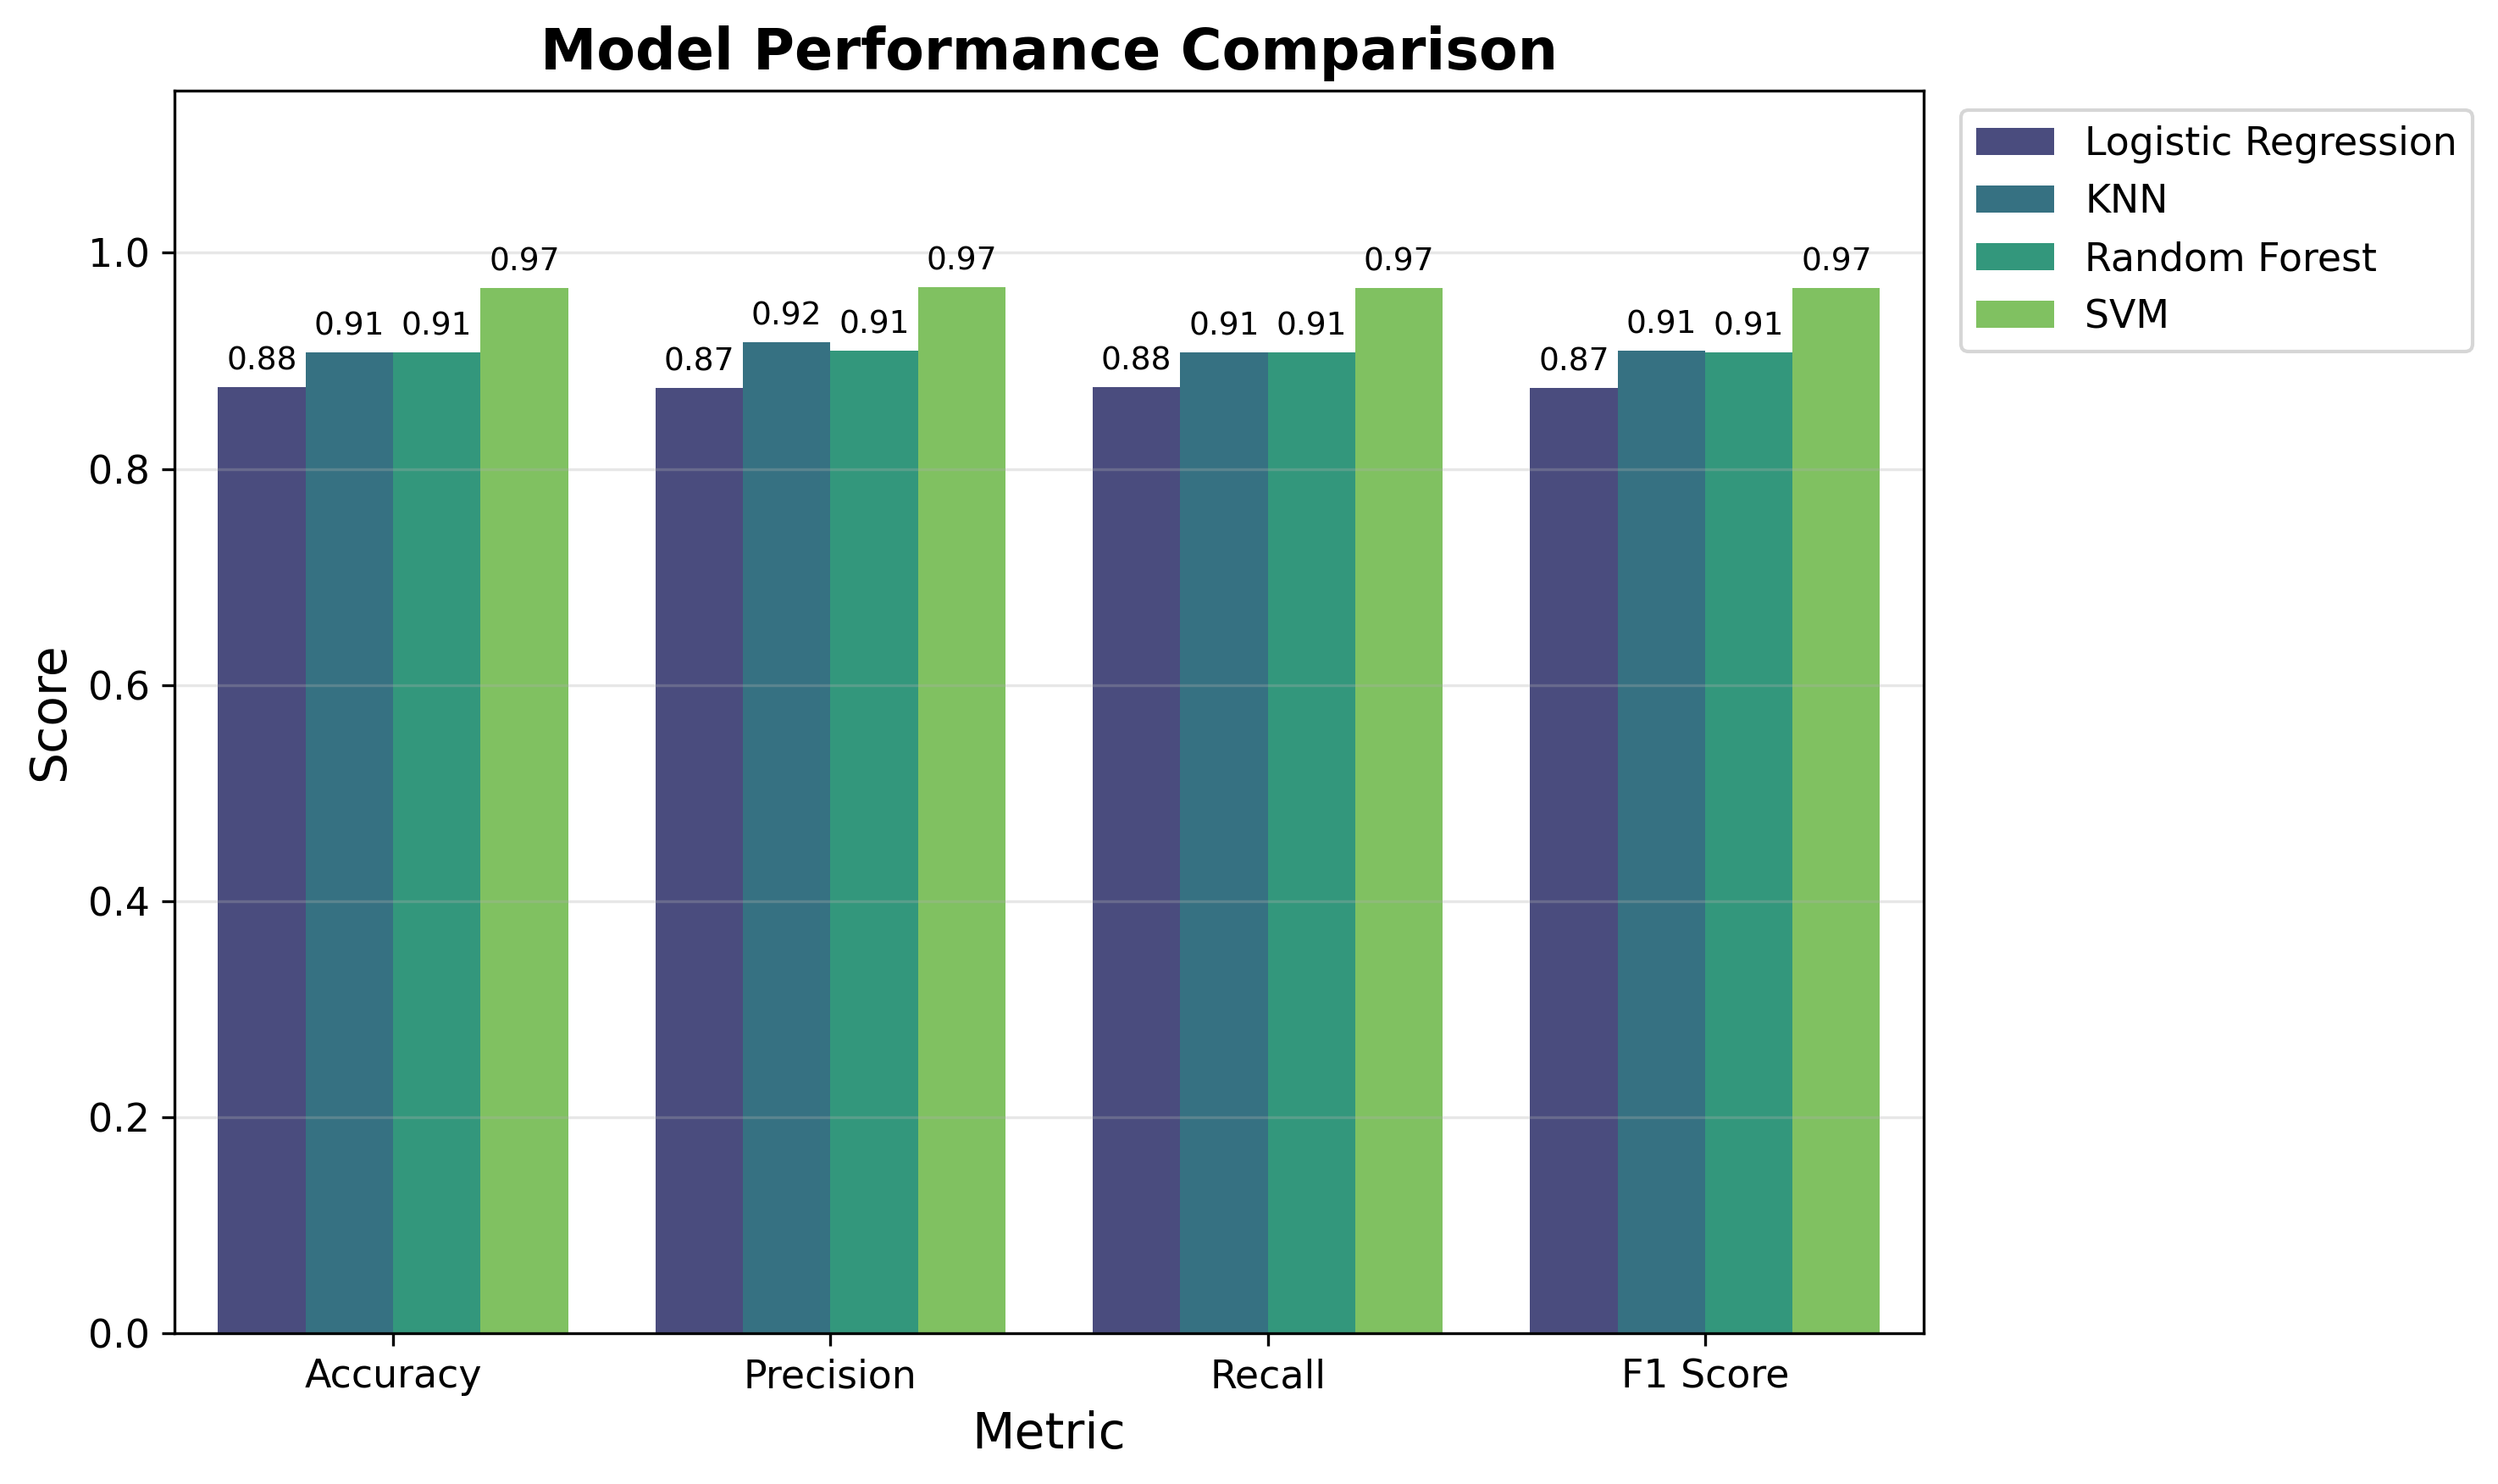

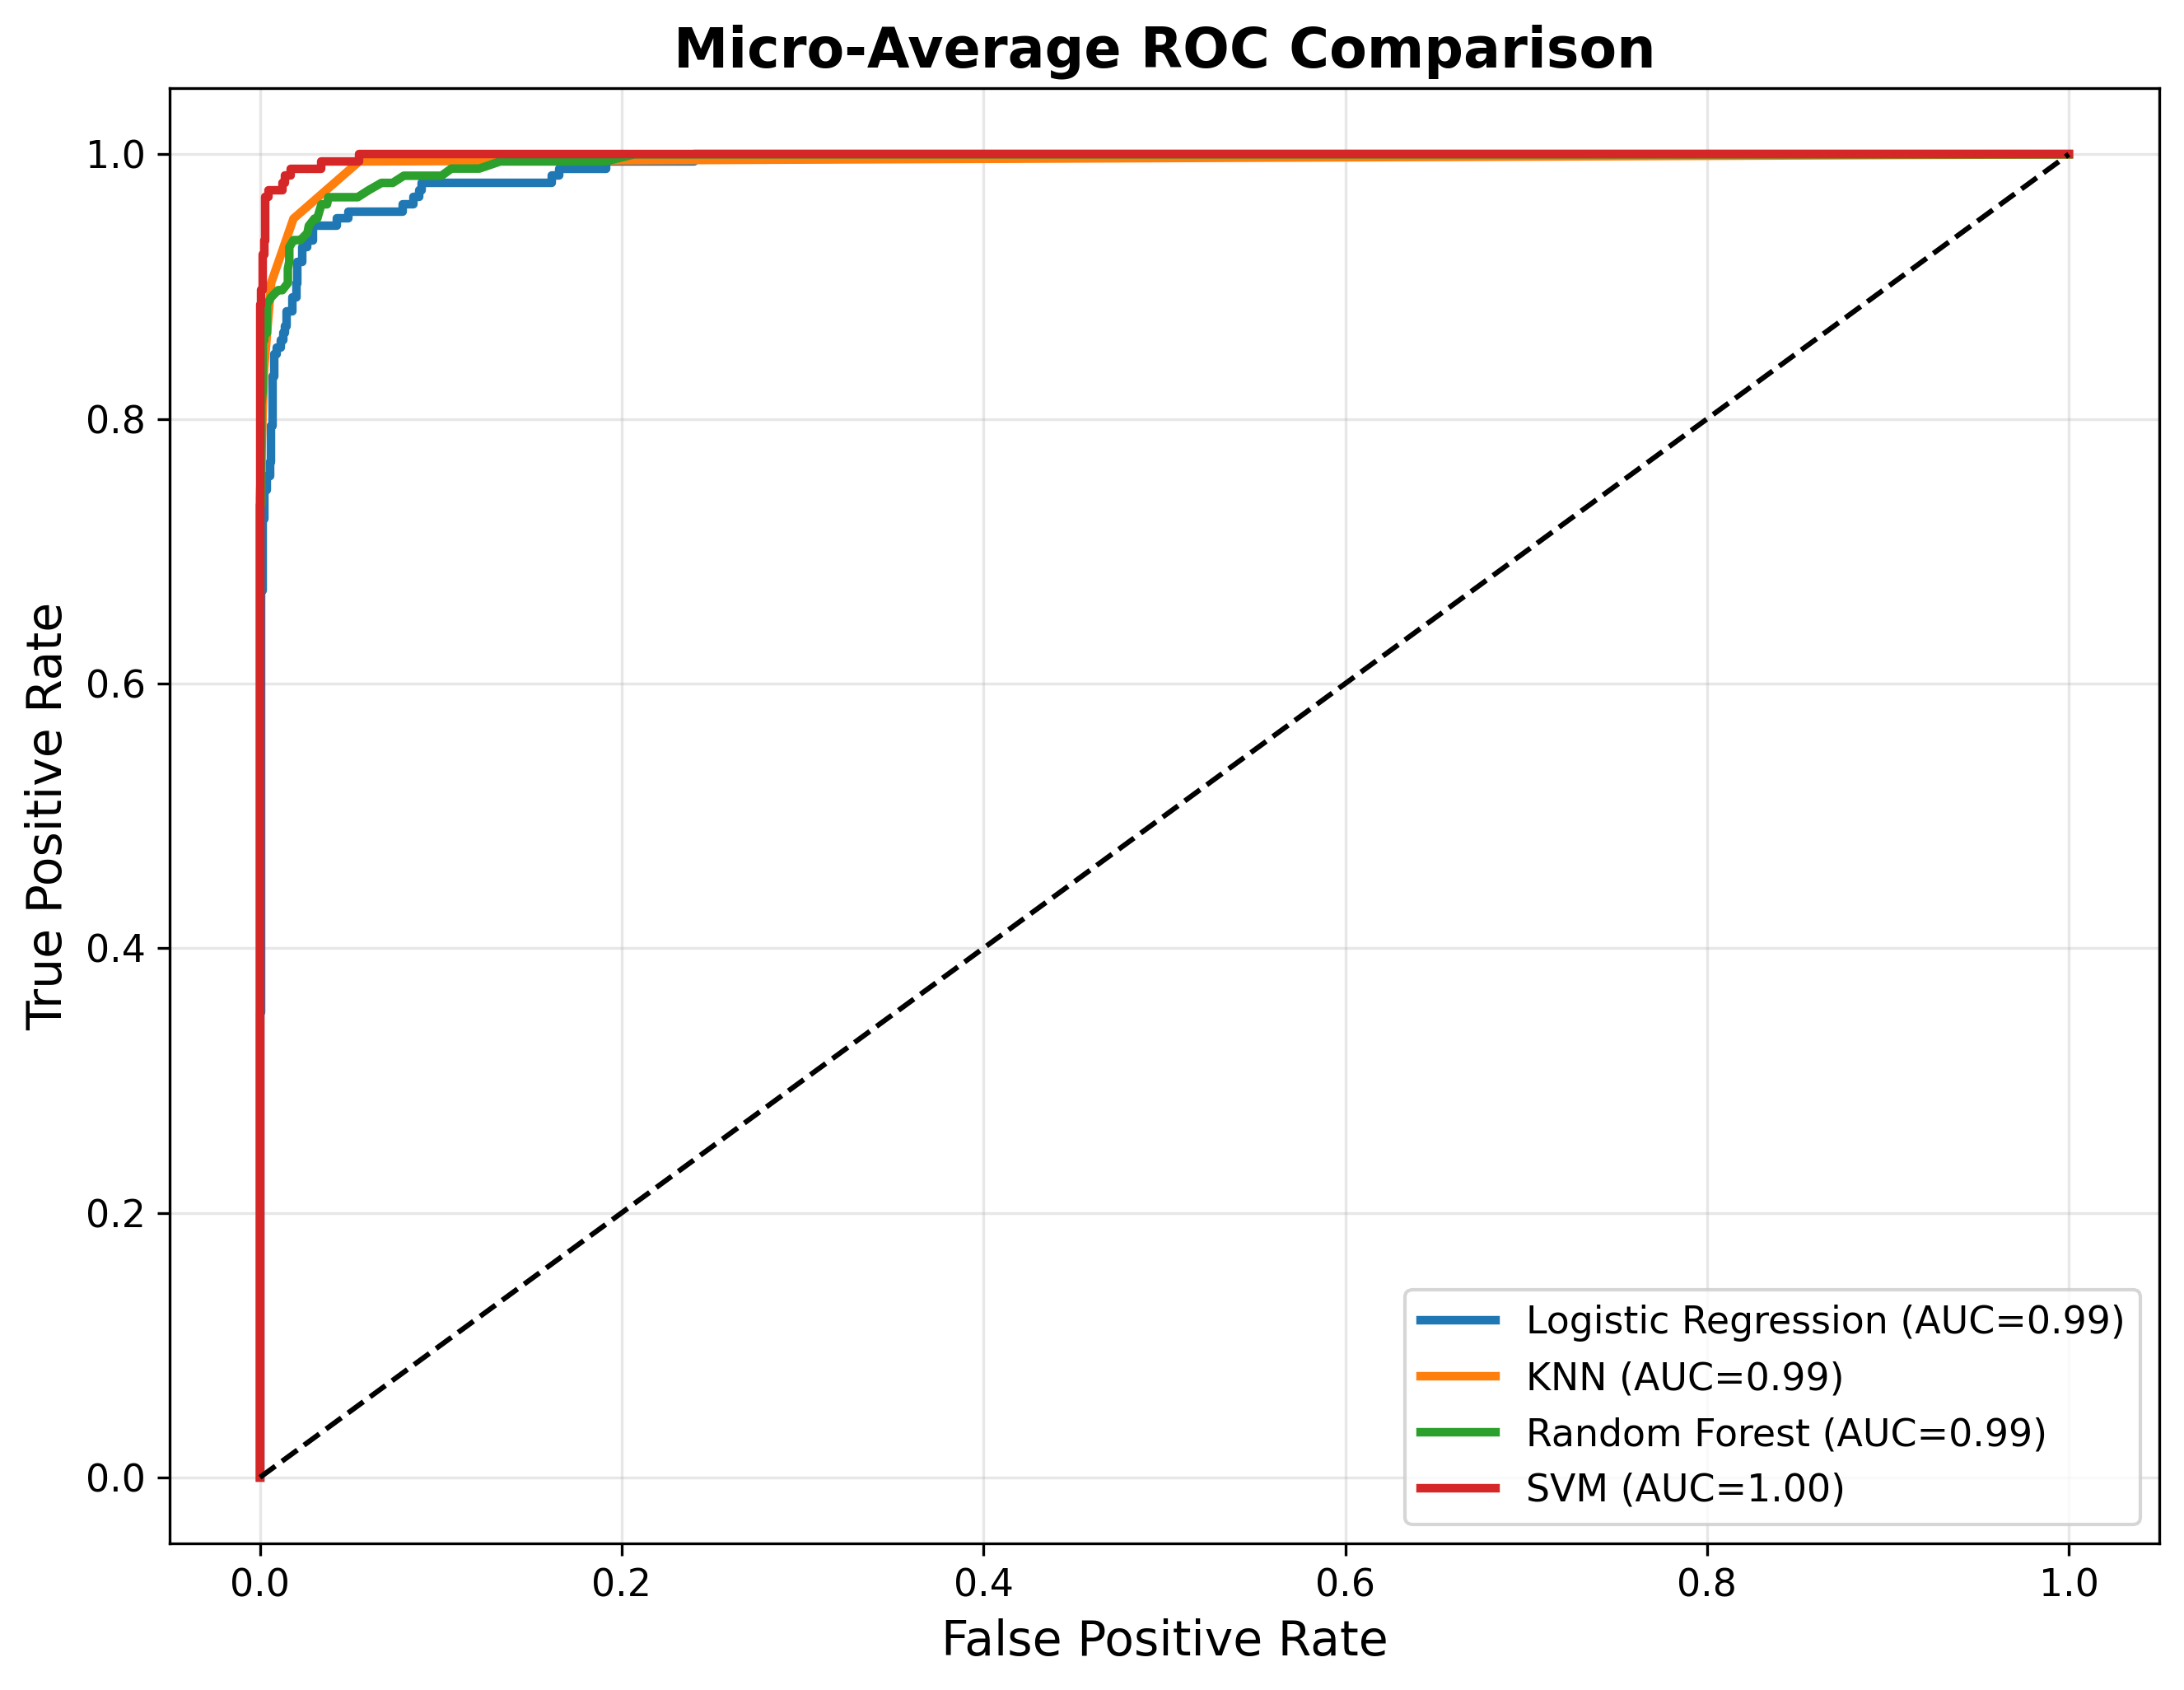

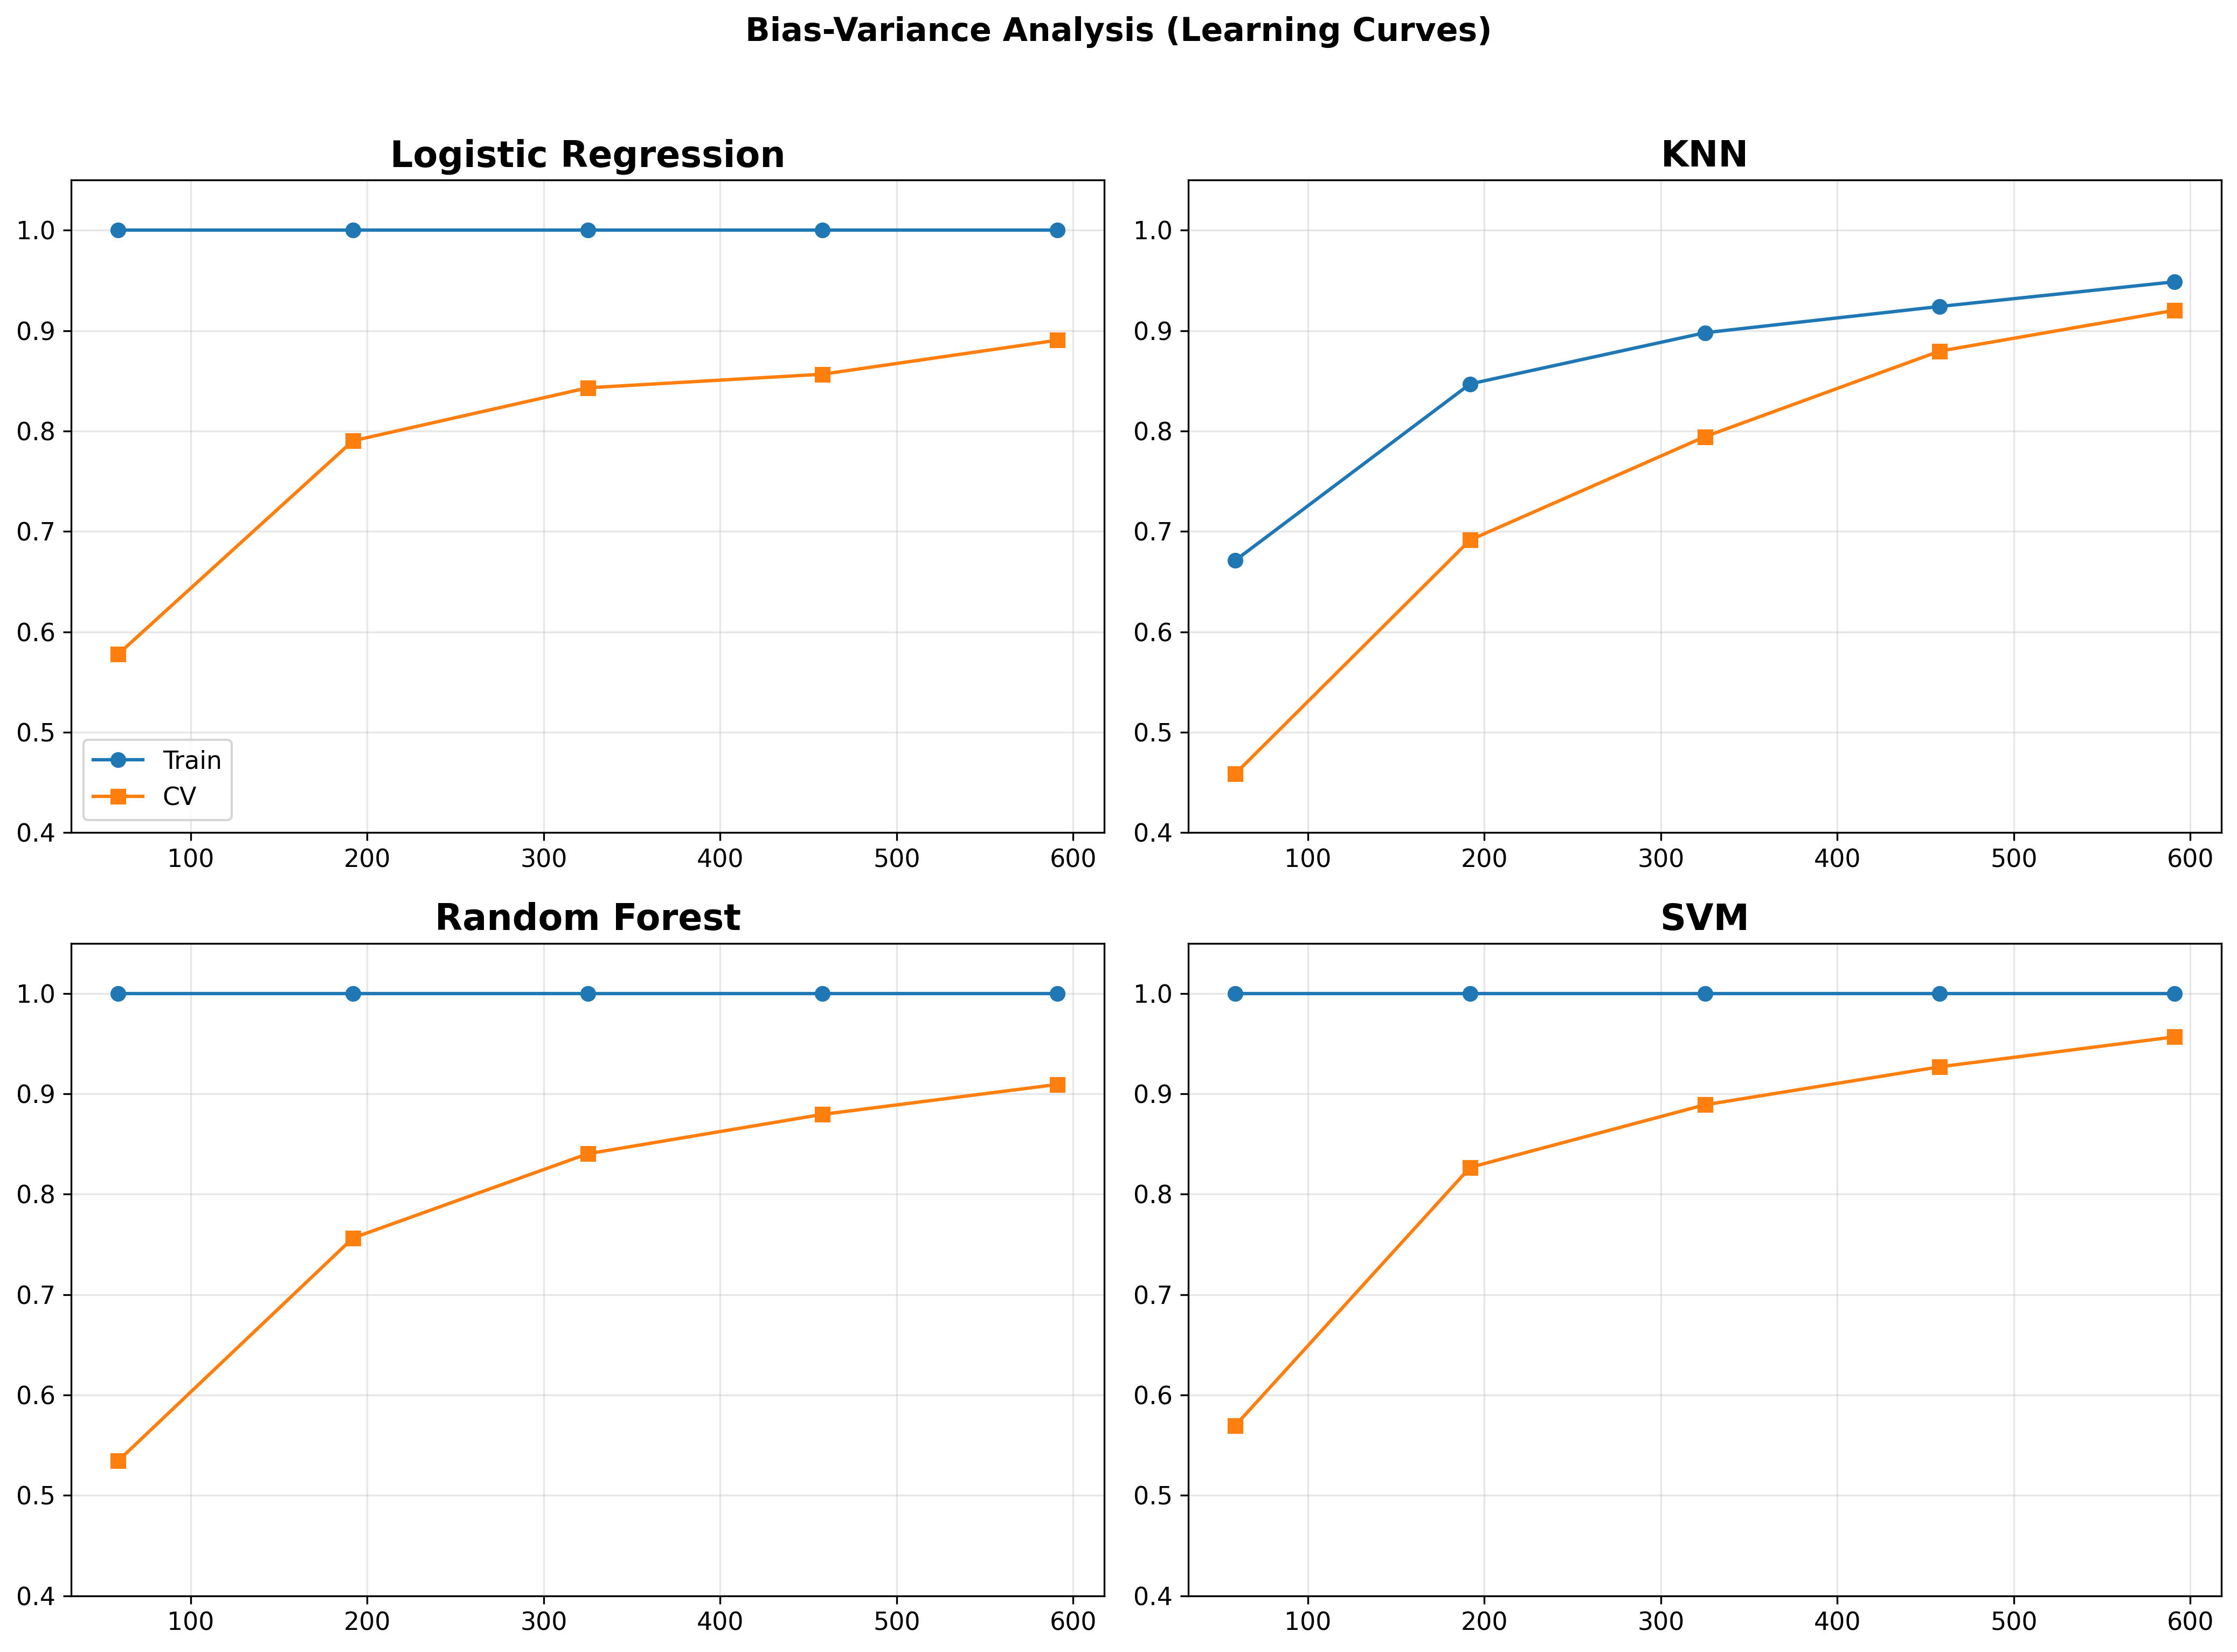

Done. Results saved to paper_results


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import joblib
from pathlib import Path
from sklearn.model_selection import GridSearchCV, learning_curve, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_curve, auc, confusion_matrix)

# PLOTTING CONFIGURATION
plt.rcParams.update({
    'font.size': 12,
    'font.family': 'sans-serif',
    'axes.labelsize': 14, 'axes.titlesize': 16,
    'legend.fontsize': 11, 'xtick.labelsize': 11, 'ytick.labelsize': 11,
    'figure.dpi': 300, 'savefig.dpi': 300, 'axes.grid': True, 'grid.alpha': 0.3
})
warnings.filterwarnings('ignore')

# CONFIG
class Config:
    train_path = "train_split.csv"
    test_path = "test_split.csv"
    out_dir = "paper_results"
    seed = 42
    cv_folds = 5
    n_jobs = -1
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

CFG = Config()
Path(CFG.out_dir).mkdir(parents=True, exist_ok=True)

# 1. DATA LOADING
def load_data():
    """Load and preprocess data."""
    print("Loading data...")
    train = pd.read_csv(CFG.train_path)
    test = pd.read_csv(CFG.test_path)

    meta_cols = ['label', 'filename', 'filepath', 'track_id', 'recording_id']
    X_train = train.drop(columns=meta_cols, errors='ignore')
    y_train = train['label']
    X_test = test.drop(columns=meta_cols, errors='ignore')
    y_test = test['label']

    le = LabelEncoder()
    y_train = le.fit_transform(y_train)
    y_test = le.transform(y_test)

    scaler = StandardScaler()
    X_train_s = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
    X_test_s = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

    return X_train_s, y_train, X_test_s, y_test, le

# 2. MODEL TRAINING
def train_models(X_train, y_train):
    """Train models with GridSearch."""
    print("Training models...")

    models = {
        'Logistic Regression': LogisticRegression(random_state=CFG.seed, max_iter=2000),
        'KNN': KNeighborsClassifier(),
        'Random Forest': RandomForestClassifier(random_state=CFG.seed),
        'SVM': SVC(probability=True, random_state=CFG.seed, kernel='rbf', class_weight='balanced')
    }

    grids = {
        'Logistic Regression': {'C': [0.1, 1, 10]},
        'KNN': {'n_neighbors': [5, 9, 15]},
        'Random Forest': {'n_estimators': [100, 200], 'max_depth': [10, 20]},
        'SVM': {'C': [1, 10], 'gamma': ['scale', 0.01]}
    }

    best_models = {}
    cv = StratifiedKFold(n_splits=CFG.cv_folds, shuffle=True, random_state=CFG.seed)

    for name, model in models.items():
        print(f"  Optimizing {name}...")
        gs = GridSearchCV(model, grids[name], cv=cv, scoring='accuracy', n_jobs=CFG.n_jobs)
        gs.fit(X_train, y_train)
        best_models[name] = gs.best_estimator_

    return best_models

# --- 3. EVALUATION ---
def evaluate(models, X_test, y_test):
    """Calculate aggregate metrics."""
    results = []
    for name, model in models.items():
        p = model.predict(X_test)
        results.append({
            'Model': name,
            'Accuracy': accuracy_score(y_test, p),
            'Precision': precision_score(y_test, p, average='weighted', zero_division=0),
            'Recall': recall_score(y_test, p, average='weighted', zero_division=0),
            'F1 Score': f1_score(y_test, p, average='weighted', zero_division=0)
        })
    return pd.DataFrame(results)

# 4. VISUALIZATION
def plot_metrics(df):
    """Grouped bar chart for all metrics."""
    plt.figure(figsize=(10, 6))
    df_melt = df.melt(id_vars="Model", var_name="Metric", value_name="Score")
    ax = sns.barplot(data=df_melt, x="Metric", y="Score", hue="Model", palette="viridis")

    for c in ax.containers:
        ax.bar_label(c, fmt='%.2f', padding=3, fontsize=9)

    plt.title("Model Performance Comparison", fontweight='bold')
    plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
    plt.ylim(0, 1.15)
    plt.tight_layout()
    plt.savefig(f"{CFG.out_dir}/Fig1_Metrics.png")
    plt.show()

def plot_combined_roc(models, X_test, y_test, le):
    """Single Micro-Average ROC plot for all models."""
    plt.figure(figsize=(9, 7))
    y_bin = label_binarize(y_test, classes=range(len(le.classes_)))

    for (name, model), color in zip(models.items(), CFG.colors):
        if hasattr(model, "predict_proba"):
            probs = model.predict_proba(X_test)
            fpr, tpr, _ = roc_curve(y_bin.ravel(), probs.ravel())
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f'{name} (AUC={roc_auc:.2f})', color=color, lw=2.5)

    plt.plot([0, 1], [0, 1], 'k--', lw=1.5)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Micro-Average ROC Comparison', fontweight='bold')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig(f"{CFG.out_dir}/Fig2_ROC.png")
    plt.show()

def plot_learning_curves(models, X_train, y_train):
    """2x2 Grid of learning curves."""
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()

    for i, (name, model) in enumerate(models.items()):
        ax = axes[i]
        sizes, train_scores, test_scores = learning_curve(
            model, X_train, y_train, cv=5, n_jobs=CFG.n_jobs,
            train_sizes=np.linspace(0.1, 1.0, 5), scoring='accuracy'
        )

        ax.plot(sizes, np.mean(train_scores, axis=1), 'o-', color=CFG.colors[0], label='Train')
        ax.plot(sizes, np.mean(test_scores, axis=1), 's-', color=CFG.colors[1], label='CV')
        ax.set_title(name, fontweight='bold')
        ax.set_ylim(0.4, 1.05)
        ax.grid(True, alpha=0.3)
        if i==0: ax.legend()

    plt.suptitle("Bias-Variance Analysis (Learning Curves)", fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig(f"{CFG.out_dir}/Fig3_LearningCurves.png")
    plt.show()

# MAIN
if __name__ == "__main__":
    X_train, y_train, X_test, y_test, le = load_data()
    models = train_models(X_train, y_train)

    metrics = evaluate(models, X_test, y_test)
    print("\nResults:\n", metrics)
    metrics.to_csv(f"{CFG.out_dir}/metrics.csv", index=False)

    print("\nGenerating Figures...")
    plot_metrics(metrics)
    plot_combined_roc(models, X_test, y_test, le)
    plot_learning_curves(models, X_train, y_train)

    print(f"Done. Results saved to {CFG.out_dir}")